# Configuration

En phase de développement, il peut être utile de faire en sorte que tout changement dans les modules importés soit immédiatement pris en compte dans le notebook.

In [1]:
%load_ext autoreload
%autoreload 2

Ci-dessous on définit le fichier permettant de charger notre jeu de données.

In [ ]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

Ensuite on définit quelques variables globales permettant de choisir ce qu'on souhaite exécuter ou non dans le notebook.

In [3]:
ACTIVATE_MLFLOW = False
MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_Philippe_{date_string}"
MLFLOW_URI = "http://truenas:35000"

PRELOAD_MODULES = True

# Chargement et préparation du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [4]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10.head())

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False


On constate que les chemins stockés dans le fichier .csv contiennent un mélange de séparateurs '/' et '\\'.

On décide d'harmoniser le tout en utilisant '/'.

In [5]:
df_pvf10["Chemin"] = df_pvf10["Chemin"].str.replace("\\", "/")

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [6]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

## Sélection des images de format carré

In [7]:
df_pvf10 = df_pvf10.loc[df_pvf10["Doute_Carre"] == False]

In [8]:
display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Pré-chargement des images (augmentées inclues)

In [9]:
if PRELOAD_MODULES:

    from pathlib import Path
    from sep24_cds_pv.features.pvmodule import PVModule

    pre_loaded_modules = []
    images_extension = Path(df_pvf10.loc[0, "Chemin"]).suffix
    dataset_basepath = Path(df_pvf10.loc[0, "Chemin"]).parents[2]

    for image_path in dataset_basepath.glob(f"**/*{images_extension}"):
        
        module = PVModule.get_module(image_path)

        pre_loaded_modules.append(module)

    print(f"Number of images found: {len(pre_loaded_modules)}")

Number of images found: 9597


## Chargement des images (objets PVModule)

In [10]:
from pathlib import Path
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    module = PVModule.get_module(image_path)
    module.extract_stats()

    modules.append(module)

Nombre de modules chargés

In [11]:
print(f"Number of modules: {len(modules)}")

Number of modules: 5338


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: 6600
Min/max: 22/239


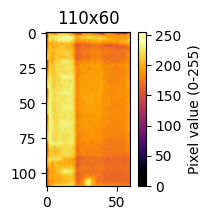

In [12]:
module = modules[0]
print(module)
module.plot()

# Définition des extracteurs

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

## Indicateurs statistiques "basiques"

In [14]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class BaseStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = [
            # Indicateurs classiques
            "mean", "median", "max", "std", "min", "ptp", 
            # Indicateurs additionnels
            "skewness", "kurtosis", "iqr_25_75",
        ]
        # Percentiles
        for p in np.arange(0.05, 1., 0.05):
            label = f"p_{p:.2f}"
            self.feature_names_.append(label)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les dict stats
        stats_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Stockage du dict stats
            module.extract_stats()
            stats_dicts.append(module.stats)
        # On renvoie le dataframe des dict stats
        return pd.DataFrame.from_records(stats_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

## Histogramme

In [15]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class HistogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = [f"hist_{idx}" 
                               for idx in range(PVModule.min_max[0],
                                                PVModule.min_max[1]+1)]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les vecteurs histogramme
        histo_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            module.extract_histogram()
            # Stockage du dict histogramme
            histo_dicts.append(module.histogram_dict)
        # On renvoie le dataframe des vecteurs stats
        return pd.DataFrame.from_records(histo_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des histogrammes.

In [16]:
import time

start  = time.time()

for module in pre_loaded_modules:
    module.extract_histogram()

end = time.time()
elapsed = end - start
print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.04 minutes (0.00042147598895476344 secondes par module)


## Vecteurs GLCM 

In [17]:
# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = PVModule.get_glcm_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vector_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_glcm()
            glcm_vector_dicts.append(module.glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame.from_records(glcm_vector_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des vecteurs GLCM.

In [18]:
import time

start  = time.time()

for module in pre_loaded_modules:
    module.extract_glcm()

end = time.time()
elapsed = end - start
print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 2.79 minutes (0.031415884125853534 secondes par module)


# Définition du ColumnDropper

Ce transformeur est utilisé pour supprimer les colonnes inutiles du dataset, détectées à l'aide d'un seuil sur l'écart-type.

In [19]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, std_threshold: float = 0.001):
        self.std_threshold = std_threshold
        self.columns_to_drop = []
        self.feature_names_ = []
        
    def fit(self, X, y):
        X = pd.DataFrame(X)
        X_std = X.std(ddof=0)
        self.columns_to_drop = X_std.loc[X_std < self.std_threshold].index.to_list()
        self.feature_names_ = list(set(X.columns) - set(self.columns_to_drop))
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        return X.drop(columns=self.columns_to_drop)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

# Définition de l'AlbumentationsOverSampler

D'abord on importe la bibliothèque `albumentations`, puis on initialise un dictionnaire qui va mapper l'ensemble des transformations qui nous intéressent avec leur nom.

In [20]:
import albumentations as A

all_transformations = {}

e:\Miniconda3\envs\DS_Project_Git\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Enregistrement de l'ensemble des transformations créées à partir de la transformation "ToGray".

In [21]:
TRANSFORM_NAME = "ToGray"
COMP_METHODS = ["weighted_average", "from_lab", "desaturation", "average", "max", "pca"]

transformations = {}

for method_name in COMP_METHODS:

    transformation_name = f"{TRANSFORM_NAME}.{method_name}"
    transformation = A.ToGray(num_output_channels=1,
                              method=method_name,
                              p=1.)

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ImageCompression".

In [22]:
TRANSFORM_NAME = "ImgComp"
COMP_METHODS = ["jpeg", "webp"]
TOGRAY_METHODS = {
    "w_avg": "weighted_average",
    "avg": "average",
}
QUALITY = [80, 90]

transformations = {}

for method_name in COMP_METHODS:
    for quality in QUALITY:
        for togray_method_shortname, togray_method_name in TOGRAY_METHODS.items():

            transformation_name = f"{TRANSFORM_NAME}.{method_name}.{quality}.{togray_method_shortname}"
            transformation = A.Compose([
                A.ImageCompression(quality_range=[quality, quality],
                                   compression_type=method_name,                                                                                       
                                   p=1.),
                A.ToGray(num_output_channels=1,
                         method=togray_method_name,
                         p=1.),
            ])

            transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "MedianBlur".

In [23]:
TRANSFORM_NAME = "MedianBlur"
BLUR_LIMITS = [3, 5]

transformations = {}

for blur_limit in BLUR_LIMITS:

    transformation_name = f"{TRANSFORM_NAME}.{blur_limit}"
    transformation = A.Compose([
        A.MedianBlur(blur_limit=[blur_limit, blur_limit],
                            p=1.),
        A.ToGray(num_output_channels=1,
                    method="weighted_average",
                    p=1.),
    ])

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Ici on définit quelles transformations seront appliquées selon la classe de défaut associée à chaque échantillon.

In [24]:
class_transformations = {
    "string short circuit": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
        "ImgComp.jpeg.80.avg",
        "ImgComp.jpeg.90.avg",
        "ImgComp.webp.80.avg", 
        "ImgComp.webp.90.avg", 
        "MedianBlur.3",
    ],
    "break": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
    ],
    "shadow": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "Debris cover": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "bottom dirt": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "short circuit panel": [
        "MedianBlur.3",
    ],
}


In [25]:
import cv2

class AlbumentationsAugmenter:
    
    def __init__(self, 
                 all_transformations: dict,
                 class_transformations: dict,
                 augmented_data_subfolder: str = "augmented",
                 ):
        self.all_transformations = all_transformations
        self.class_transformations = class_transformations
        self.augmented_data_subfolder = augmented_data_subfolder
    
    def augmentation(self, module: PVModule):
        # On récupère la classe du module passé en paramètre
        defect_class = module.status
        # On en déduit la liste des transformations à appliquer
        transformations_list = self.class_transformations.get(defect_class, [])
        # On Récupère les modules "transformés" correspondants
        new_modules = []
        for transformation_name in transformations_list:
            # Définition du chemin de l'image transformée
            class_folder = f"xx{defect_class}"
            new_image_path = (module.image_path.parents[2] 
                              / self.augmented_data_subfolder 
                              / class_folder 
                              / f"{module.image_path.stem}.{transformation_name}.png")
            # Si l'image n'existe pas déjà, on la crée et on la sauvegarde
            if not new_image_path.exists():
                # Transformation
                transformation = self.all_transformations[transformation_name]
                transformed_image = transformation(image=module.color_array)['image']
                # Sauvegarde de l'image transformée
                new_image_path.parent.mkdir(exist_ok=True, parents=True)
                cv2.imwrite(new_image_path, transformed_image)
            # Ensuite on peut charge l'objet PVModule correspondant
            new_modules.append(PVModule.get_module(new_image_path))
        return new_modules

    def resample(self, X, y):
        # On itère sur chaque module du dataset X 
        # pour récupérer le chemin et la classe des nouveaux modules "augmentés"
        all_augmented_modules_dicts = []
        for row in X.itertuples(index=False):
            image_path = Path(row.Chemin)
            module = PVModule.get_module(image_path)
            augmented_modules = self.augmentation(module)
            augmented_modules_dicts = [{
                "Chemin": mod.image_path,
                "Format": mod.format,
                "Train_Test": self.augmented_data_subfolder,
                "Classe": mod.status,
                "Nom": mod.image_path.stem,
            }
                                 for mod in augmented_modules]
            all_augmented_modules_dicts += augmented_modules_dicts

        # On crée le dataframe Xy des modules augmentés
        Xy_augmentation = pd.DataFrame(all_augmented_modules_dicts) 
        # On crée le dataframe X augmenté
        X_augmented = pd.concat([X, Xy_augmentation.drop(columns=["Classe"])], axis=0)
        # On crée le vecteur y augmenté
        y_augmented = pd.concat([y, Xy_augmentation["Classe"]], axis=0)

        return X_augmented, y_augmented
    

On termine en créant le sampler à l'aide de la classe FunctionSampler de la bibliothèque `imblearn`.

In [26]:
from imblearn import FunctionSampler

# Pour que le nom réel du sampler utilisé apparaisse dans l'affichage html du pipeline, 
# on crée une classe 'AlbumentationsOverSampler' qui hérite simplement de la classe 'FunctionSampler' de imblearn
class AlbumentationsOverSampler(FunctionSampler):
    ...

albumentations_oversampler = AlbumentationsOverSampler(
    func=AlbumentationsAugmenter(all_transformations, class_transformations).resample,
    validate=False)


# Séparation du jeu de données


Train, Validation & Test.


In [27]:
TRAIN_SIZE = .8
TEST_SIZE = .2
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Leave random_state to None for non-reproducible shuffling

In [28]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

In [29]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

In [30]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

def display_dataset_proportions(dataset: pd.Series):
    display(pd.concat([pd.Series(dataset).value_counts(),
                       pd.Series(dataset).value_counts(normalize=True) * 100],
                      axis=1))


for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        display_dataset_proportions(split)


---------------------------------
Split: y_train

Nombre d'éléments: 4270
Proportion du jeu complet: 79.99%


,count,proportion
Classe,,
healthy panel,1165,27.283372
hot cell,676,15.831382
junction box heat,640,14.988290
substring open circuit,475,11.124122
short circuit panel,341,7.985948
bottom dirt,302,7.072600
Debris cover,268,6.276347
shadow,242,5.667447
break,104,2.435597


---------------------------------
Split: y_test

Nombre d'éléments: 1068
Proportion du jeu complet: 20.01%


,count,proportion
Classe,,
healthy panel,291,27.247191
hot cell,169,15.823970
junction box heat,160,14.981273
substring open circuit,119,11.142322
short circuit panel,86,8.052434
bottom dirt,75,7.022472
Debris cover,67,6.273408
shadow,61,5.711610
break,26,2.434457


---------------------------------
Split: y_validation

Nombre d'éléments: 0
Proportion du jeu complet: 0.00%


## Vérification du fonctionnement du sampler

On vérifie que l'utilisation du sampler permet bien de compenser les classes minoritaires selon les taux d'augmentation définis.

In [31]:
X_train_resampled, y_train_resampled = albumentations_oversampler.fit_resample(X_train, y_train)

In [32]:
display_dataset_proportions(y_train_resampled)

,count,proportion
Classe,,
healthy panel,1165,15.562383
bottom dirt,906,12.102592
Debris cover,804,10.740048
break,728,9.724820
shadow,726,9.698103
string short circuit,684,9.137056
short circuit panel,682,9.110339
hot cell,676,9.030190
junction box heat,640,8.549292


# Modélisation

In [33]:
# Pipeline
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Selector
from sklearn.feature_selection import SelectKBest

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modèles à évaluer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


## Classes complémentaires

### FeatureUnion 'custom'

Afin de conserver les noms de colonnes après l'étape de transformation, on définit un FeatureUnion 'custom'.

In [34]:
from joblib import Parallel, delayed

class DataFrameFeatureUnion(FeatureUnion):

    # Méthode pour ajuster les transformeurs
    def fit(self, X, y=None, **fit_params):
        # Valider les transformeurs avant de les utiliser
        self._validate_transformers()
        # Récupérer les paramètres de fit associés à chaque transformeur
        fit_params_all = self._get_fit_params(fit_params)
        # Appliquer chaque transformeur en parallèle avec les bons paramètres de fit
        self._fit_transformers = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(name, trans, X, y, fit_params_all.get(name, {}))
            for name, trans in self.transformer_list
        )
        return self

    # Méthode pour transformer les données après les avoir ajustées
    def transform(self, X):
        # Appliquer chaque transformeur déjà ajusté en parallèle
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._transform_one)(name, trans, X)
            for name, trans in self._fit_transformers
        )
        # Concatenation des résultats de transformation dans un DataFrame
        return pd.concat(results, axis=1)

    # Méthode qui effectue à la fois le fit et la transformation
    def fit_transform(self, X, y=None, **fit_params):
        # Valider les transformeurs avant de les utiliser
        self._validate_transformers()
        # Récupérer les paramètres de fit associés à chaque transformeur
        fit_params_all = self._get_fit_params(fit_params)
        # Appliquer chaque transformeur en parallèle avec fit et transformation
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_transform_one)(name, trans, X, y, fit_params_all.get(name, {}))
            for name, trans in self.transformer_list
        )
        # Stocker les transformeurs ajustés pour une utilisation future
        self._fit_transformers = [(name, trans) for name, _, trans in results]
        # Concatenation des résultats de fit et transformation dans un DataFrame
        return pd.concat([Xt for _, Xt, _ in results], axis=1)

    # Méthode privée pour ajuster un seul transformeur
    def _fit_one(self, name, trans, X, y, fit_params):
        return name, trans.fit(X, y, **fit_params)

    # Méthode privée pour appliquer un transformeur déjà ajusté
    def _transform_one(self, name, trans, X):
        Xt = trans.transform(X)
        return self._rename_columns(Xt, name)

    # Méthode privée pour effectuer à la fois le fit et la transformation pour un seul transformeur
    def _fit_transform_one(self, name, trans, X, y, fit_params):
        Xt = trans.fit_transform(X, y, **fit_params)
        Xt = self._rename_columns(Xt, name)
        return name, Xt, trans

    # Méthode privée pour renommer les colonnes du DataFrame transformé
    def _rename_columns(self, Xt, prefix):
        if isinstance(Xt, pd.DataFrame):
            Xt = Xt.copy()
            # Ajouter un préfixe au nom de chaque colonne
            Xt.columns = [f"{prefix}__{col}" for col in Xt.columns]
        else:
            Xt = pd.DataFrame(Xt)
            # Ajouter un préfixe avec des indices numériques pour les colonnes
            Xt.columns = [f"{prefix}__{i}" for i in range(Xt.shape[1])]
        return Xt

    # Méthode privée pour extraire les paramètres de fit spécifiques à chaque transformeur
    def _get_fit_params(self, fit_params):
        fit_params_all = {}
        for key, value in fit_params.items():
            if '__' in key:
                # Extraire le nom du transformeur et du paramètre
                step, param = key.split('__', 1)
                # Organiser les paramètres pour chaque transformeur
                fit_params_all.setdefault(step, {})[param] = value
        return fit_params_all


### Wrapper XGBoost

XGBoost ne travaille que sur des valeurs numériques.

Pour pouvoir néanmoins utiliser un classifieur XGBoost comme les autres modèles Scikit-learn, il est nécessaire de le 'wrapper' dans un estimateur qui intègre les étapes d'encodage/décodage des classes de défaut dans le vecteur 'y'.

In [35]:
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError

class XGBClassifierWithLabelEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        # Dynamically store XGBoost parameters
        for key, value in xgb_params.items():
            setattr(self, key, value)
        self.encoder = LabelEncoder()
        self.clf = None
        self._is_fitted = False

    def fit(self, X, y):
        y_enc = self.encoder.fit_transform(y)

        # Extract valid XGB params from self
        params = self._get_xgb_params()
        self.clf = XGBClassifier(**params)
        self.clf.fit(X, y_enc)

        # Mark as fitted and expose attributes
        self._is_fitted = True
        # self.classes_ = self.encoder.classes_
        # self.n_features_in_ = X.shape[1]
        # if hasattr(X, "columns"):
        #     self.feature_names_in_ = X.columns

        return self

    def predict(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        y_pred_enc = self.clf.predict(X)
        return self.encoder.inverse_transform(y_pred_enc)

    def predict_proba(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.predict_proba(X)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_') and k not in ['encoder', 'clf']
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _get_xgb_params(self):
        valid_params = XGBClassifier().get_params()
        return {
            k: v for k, v in self.get_params().items()
            if k in valid_params
        }

    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

## Configuration du pipeline

### Pipeline générique

In [36]:

# Pipeline générique
pipe = Pipeline([
    ('sampler', albumentations_oversampler),  # Placeholder, remplacé dans la grid
    ('features', DataFrameFeatureUnion([
        ('stats', BaseStatsExtractor()),  # Placeholder, remplacé dans la grid
        ('histogram', HistogramExtractor()),  # Placeholder, remplacé dans la grid
        ('glcm', GLCMExtractor()),  # Placeholder, remplacé dans la grid
    ])),
    ('dropper', ColumnDropper()),
    ('scaler', StandardScaler()),  # Placeholder, remplacé dans la grid
    ('selector', SelectKBest(k="all")),  # Placeholder, remplacé dans la grid
('model', LogisticRegression(max_iter=1000))  # Placeholder, remplacé dans la grid
],
)

### Paramétrage

Paramétrage des samplers à évaluer.

In [37]:
sampler_param_grid = [
    # {
    #     'sampler': [albumentations_oversampler],
    # },
    {
        'sampler': ['passthrough'],
    }
]

Paramétrage des extracteurs.

In [38]:
extractors_param_grid = [
    {
        "features__stats": [BaseStatsExtractor()],
        "features__histogram": [HistogramExtractor()],
        "features__glcm": [GLCMExtractor()],
        # Ajouter Canny
        # Ajouter entropie
    }
]

Paramétrage du sélecteur (KBest).

In [39]:

selector_param_grid = [
    {
        'selector': ['passthrough'],
    },
    # {
    #     'selector': [SelectKBest()],
    #     # 'selector__k' : [50, 100, 150, 200, 'all'],
    #     'selector__k' : ['all'],
    # }
]

Paramétrage des scalers.

In [40]:
scaler_param_grid = [
    {    
        "scaler": [
            StandardScaler(),
            # MinMaxScaler(),
            # RobustScaler(),
        ]
    }
]

Paramétrage des estimateurs (modèles).

In [41]:
model_param_grid = [
    {
        'model': [LogisticRegression(max_iter=1000)],
        # 'model__C': [0.1, 1, 10],
        # 'model__C': [10],
        # 'model__penalty': ['l2'],
    },
    # {
    #     'model': [SVC()],
    #     # 'model__C': [0.1, 1, 10],
    #     # 'model__kernel': ['linear', 'rbf', 'poly'],
    #     # "model__gamma": ["scale", 0.001, 0.1, 0.5],
    #     # "model__class_weight": ["balanced", None]
    #     'model__C': [10],
    #     'model__kernel': ['rbf'],
    #     "model__gamma": ["scale"],
    # },
    # {
    #     'model': [KNeighborsClassifier()],
    #     # "model__n_neighbors": np.arange(2, 20),
    #     # "model__metric": ["minkowski", "manhattan", "chebyshev"],
    #     # "model__weights": ["uniform", "distance"],
    #     # "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    #     "model__n_neighbors": [12],
    #     "model__metric": ["manhattan"],
    #     "model__weights": ["distance"],
    #     "model__algorithm": ["auto"],
    # },
    # {
    #     'model': [DecisionTreeClassifier()],
    #     "model__max_depth": [10],
    #     "model__criterion": ["entropy", "log_loss"],
    # },
    # {
    #     'model': [AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     "model__n_estimators": [190],
    #     "model__learning_rate": [1.],
    # },
    # {
    #     'model': [BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     "model__n_estimators": np.arange(100, 500, 100),
    # },
    # {
    #     'model': [RandomForestClassifier()],
    #     # 'model__n_estimators': np.arange(10, 100, 10),
    #     # "model__criterion": ["entropy", "gini", "log_loss"],
    #     # "model__max_depth": np.arange(2, 20),
    #     'model__n_estimators': [80],
    #     "model__criterion": ["entropy"],
    #     "model__max_depth": [18],
    # },
    # {
    #     'model': [MLPClassifier(max_iter=10000, alpha=0.0001, early_stopping=True)],
    #     'model__hidden_layer_sizes': [
    #         # (10,),
    #         # (50,),
    #         # (100,),
    #         # (10, 10),
    #         # (50, 50),
    #         (100, 100),
    #         # (10, 10, 10),
    #         # (50, 50, 50),
    #         # (100, 100, 100),
    #         ],
    #     # 'model__solver': ["adam", "lbfgs", "sgd"],
    #     # "model__activation": ["logistic", "tanh", "relu"],
    #     'model__solver': ["lbfgs"],
    #     "model__activation": ["tanh"],
    # },
    # {
    #     'model': [XGBClassifierWithLabelEncoding(eval_metric='logloss', tree_method="hist")],
    #     # 'model__n_estimators': np.arange(100, 400, 100),
    #     # 'model__max_depth': np.arange(4, 8, 1),
    #     # 'model__learning_rate': [0.01, 0.1, 0.3],
    #     # 'model__subsample': [0.8, 1.0],
    #     'model__n_estimators': [100],
    #     'model__max_depth': [7],
    #     'model__learning_rate': [0.1],
    #     # 'model__subsample': [0.8, 1.0],
    # },
]

### Combinaison de l'ensemble des paramètres

In [42]:
param_grid = []

for model_dict in model_param_grid:
    for extractor_dict in extractors_param_grid:
        for scaler_dict in scaler_param_grid:
            for selector_dict in selector_param_grid:
                for sampler_dict in sampler_param_grid:
                    full_dict = {}
                    full_dict.update(model_dict)
                    full_dict.update(extractor_dict)
                    full_dict.update(scaler_dict)
                    full_dict.update(selector_dict)
                    full_dict.update(sampler_dict)
                    param_grid.append(full_dict)

In [43]:
len(param_grid)

1

## MLflow

In [44]:
# Trouver le moyen 
#   - de logger aussi les résultats obtenus sur le jeu de test (X_test) pour chaque run MLflow
#   - de désactiver facilement la remontée de données MLflow (si on ne dispose pas d'un serveur MLflow)

In [45]:
import arrow

current_dt = arrow.utcnow()

if ACTIVATE_MLFLOW:
    import mlflow 

    mlflow.set_tracking_uri(MLFLOW_URI)
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(date_string=current_dt.format('YYYYMMDD_HHmm')))
    # Enable autologging
    # Autologging must be enabled before scikit-learn metric APIs are imported from sklearn.metrics
    # https://mlflow.org/docs/latest/api_reference/python_api/mlflow.sklearn.html#post-training-metrics
    mlflow.sklearn.autolog(
        log_models=True,
        silent=True,
    )

## Exécution du GridSearch

In [46]:
# Comprendre pourquoi l'exécution du 1er gridsearch prend beaucoup plus de temps
# extracteur GLCM ?
# Est-ce que ça ne le fait qu'avec l'estimateur LogisticRegression ?


-------------------------------------------------------------------------
Evaluation du pipeline: LogisticRegression_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Temps nécessaire : 2.08 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x00000208FA2BB980>>,
                                                                  validate=False)),
                                       ('features',
                                        DataFrameFeatureUnion(transformer_list=[('stats',
                                                                                 BaseStatsExtractor()),
                                                                                (...
             n_jobs=-1,
             param_grid={'features__glcm': [GLCMExtractor()],
                         'features__histogram': [HistogramExtractor()],
                         'features__stats': [BaseStatsExtractor()],
                         'model': [LogisticRegression(max_iter=1000)],
                         'sampler': ['passthrough'],
                         'scaler': [StandardScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__glcm': GLCMExtractor(),
 'features__histogram': HistogramExtractor(),
 'features__stats': BaseStatsExtractor(),
 'model': LogisticRegression(max_iter=1000),
 'sampler': 'passthrough',
 'scaler': StandardScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.6605658955623692

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


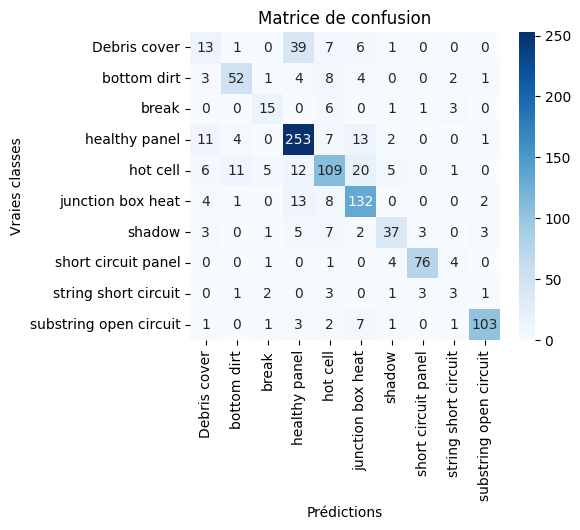

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.32      0.19      0.24        67
           bottom dirt       0.74      0.69      0.72        75
                 break       0.58      0.58      0.58        26
         healthy panel       0.77      0.87      0.82       291
              hot cell       0.69      0.64      0.67       169
     junction box heat       0.72      0.82      0.77       160
                shadow       0.71      0.61      0.65        61
   short circuit panel       0.92      0.88      0.90        86
  string short circuit       0.21      0.21      0.21        14
substring open circuit       0.93      0.87      0.90       119

              accuracy                           0.74      1068
             macro avg       0.66      0.64      0.64      1068
          weighted avg       0.73      0.74      0.73      1068



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
0,LogisticRegression_noSampling,1,"{'features__glcm': GLCMExtractor(), 'features_...",96.551055,23.034285,0.744965,0.012836,0.660566,0.010958,0.742509,0.644936,0.734787


In [47]:
import time
from pprint import pprint
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sep24_cds_pv.features.model_selection import display_results


# Extraction du type de modèle
def extract_model_name(param_dict):
    model = param_dict.get('model')[0]
    return model.__class__.__name__ if model is not None else 'unknown'

# Extraction du sampler
def extract_sampler_name(param_dict):
    sampler = param_dict.get('sampler')[0]
    if isinstance(sampler, str):
        ret_val = "noSampling"
    else:
        ret_val = sampler.__class__.__name__
    return ret_val

results_list = []

for model_param_grid in param_grid:

    start = time.time()
    
    pipeline_id = f"{extract_model_name(model_param_grid)}_{extract_sampler_name(model_param_grid)}"
    print()
    print("-------------------------------------------------------------------------")
    print(f"Evaluation du pipeline: {pipeline_id}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(estimator=pipe, 
                        param_grid=model_param_grid, 
                        # param_grid={}, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        n_jobs=-1, 
                        verbose=2)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :")
    print("Meilleurs paramètres (f1 macro) : ")
    pprint(grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)
    results["pipeline_id"] = pipeline_id

    # Calcul des prévisions sur le jeu de test
    y_test_pred = grid.best_estimator_.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
    test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
    test_recall_macro = recall_score(y_test, y_test_pred, average="macro")
    test_recall_weighted = recall_score(y_test, y_test_pred, average="weighted")
    test_precision_macro = precision_score(y_test, y_test_pred, average="macro")
    test_precision_weighted = precision_score(y_test, y_test_pred, average="weighted")    
       
    # Ajouter les scores obtenus sur le jeu de test, pour le meilleur estimateur trouvé
    best_idx = grid.best_index_
    results.loc[best_idx, "test_accuracy"] = test_accuracy
    results.loc[best_idx, "test_f1_macro"] = test_f1_macro
    results.loc[best_idx, "test_f1_weighted"] = test_f1_weighted
    results.loc[best_idx, "test_recall_macro"] = test_recall_macro
    results.loc[best_idx, "test_recall_weighted"] = test_recall_weighted
    results.loc[best_idx, "test_precision_macro"] = test_precision_macro
    results.loc[best_idx, "test_precision_weighted"] = test_precision_weighted

    # Affichage des résultats
    print()
    print("--------------------------------")
    print("Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :")

    display_results(y_test, y_test_pred)

    display(results[['pipeline_id',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     "test_accuracy", "test_f1_macro", "test_f1_weighted",
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    results_list.append(results)


## Compilation des résultats

In [48]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__glcm,param_features__histogram,param_features__stats,param_model,param_sampler,param_scaler,...,std_test_f1_macro,rank_test_f1_macro,pipeline_id,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted
0,96.551055,0.224546,23.034285,0.049931,GLCMExtractor(),HistogramExtractor(),BaseStatsExtractor(),LogisticRegression(max_iter=1000),passthrough,StandardScaler(),...,0.010958,1,LogisticRegression_noSampling,0.742509,0.644936,0.734787,0.637378,0.742509,0.658253,0.732848


## Sauvegarde du fichier de résultats

In [49]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmm')}.csv"
results_df.to_csv(filepath, index=False, sep=";")

# Exploration des résultats

In [50]:
# Extraire le type de modèle
def extract_model_name(param_dict):
    model = param_dict.get('model')
    return model.__class__.__name__ if model is not None else 'unknown'

results_df['model_name'] = results_df['params'].apply(extract_model_name)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"   {k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [51]:
# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "⏱️ Précision vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "mean_test_f1_macro": "⏱️ F1_macro vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "test_accuracy": "⏱️ Précision vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de test",
    "test_f1_macro": "⏱️ F1_macro vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de test",
}

In [52]:
import plotly.express as px
import plotly.graph_objects as go

# Création du graphique interactif pour chaque cas

for score, title in scores.items():
    
    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score].idxmax()
    best_row = results_df.loc[best_idx]

    fig = px.scatter(
        results_df,
        x='mean_fit_time',
        y=score,
        color='model_name',
        hover_data={
            'model_name': True,
            'params_str': True,
            'mean_fit_time': ':.2f',
            score: ':.4f',
        },
        title=title
    )
    fig.update_traces(marker=dict(size=7, line=dict(width=1, color='DarkSlateGrey')))

    # Ajouter un marqueur spécial pour le meilleur point
    fig.add_trace(go.Scatter(
        x=[best_row['mean_fit_time']],
        y=[best_row[score]],
        mode='markers+text',
        marker=dict(
            color='red',
            size=12,
            symbol='star'
        ),
        # text=["🏆"],
        textposition="top center",
        hoverinfo='skip',  # pour ne pas gêner les tooltips de px
        showlegend=False
    ))

    fig.update_layout(legend_title_text='Modèle', height=600)
    fig.show()
